In [2]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import IPython.display
import os
import glob
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential
from tqdm.notebook import tqdm
import librosa.display
import matplotlib.pyplot as plt

# Load the training data and testing data

##  Training data

In [3]:
CLEAN_PATH = os.path.join('data', 'clean_audio')
NOISY_PATH = os.path.join('data', 'noisy_audio')

clean_audio = glob.glob(CLEAN_PATH + '/*.wav')
noisy_audio = glob.glob(NOISY_PATH + '/*.wav')

In [4]:
clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_audio[0]),desired_channels=1)
for i in tqdm(clean_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    clean_sounds_list = tf.concat((clean_sounds_list,so),0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_audio[0]),desired_channels=1)
for i in tqdm(noisy_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    noisy_sounds_list = tf.concat((noisy_sounds_list,so),0)

clean_sounds_list.shape, noisy_sounds_list.shape

  0%|          | 0/3301 [00:00<?, ?it/s]

  0%|          | 0/3301 [00:00<?, ?it/s]

(TensorShape([154335532, 1]), TensorShape([154335532, 1]))

In [5]:
batching_size = 8000

clean_train, noisy_train = [],[]

for i in tqdm(range(0,clean_sounds_list.shape[0]-batching_size,batching_size)):
    clean_train.append(clean_sounds_list[i:i+batching_size])
    noisy_train.append(noisy_sounds_list[i:i+batching_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

clean_train.shape, noisy_train.shape

  0%|          | 0/19291 [00:00<?, ?it/s]

(TensorShape([19291, 8000, 1]), TensorShape([19291, 8000, 1]))

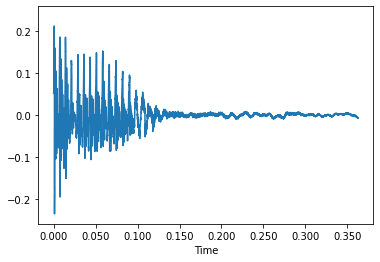

In [6]:
librosa.display.waveshow(np.squeeze(clean_train[3].numpy(),axis=-1))
plt.show()
librosa.display.waveshow(np.squeeze(noisy_train[3].numpy(),axis=-1))
plt.show()

In [7]:
clean_train.shape

TensorShape([19291, 8000, 1])

##  Testing data

In [8]:
TEST_CLEAN_PATH = os.path.join('data', 'clean_testset_wav')
TEST_NOISY_PATH = os.path.join('data', 'noisy_testset_wav')

test_clean_audio = glob.glob(TEST_CLEAN_PATH + '/*.wav')
test_noisy_audio = glob.glob(TEST_NOISY_PATH + '/*.wav')

In [9]:
test_clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(test_clean_audio[0]),desired_channels=1)
for i in tqdm(test_clean_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    test_clean_sounds_list = tf.concat((test_clean_sounds_list,so),0)

test_noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(test_noisy_audio[0]),desired_channels=1)
for i in tqdm(test_noisy_audio[1:]):
    so,_ = tf.audio.decode_wav(tf.io.read_file(i),desired_channels=1)
    test_noisy_sounds_list = tf.concat((test_noisy_sounds_list,so),0)

test_clean_sounds_list.shape, test_noisy_sounds_list.shape

  0%|          | 0/392 [00:00<?, ?it/s]

  0%|          | 0/392 [00:00<?, ?it/s]

(TensorShape([48203468, 1]), TensorShape([48203468, 1]))

In [10]:
test_clean_train, test_noisy_train = [],[]

for i in tqdm(range(0, test_clean_sounds_list.shape[0]-batching_size, batching_size)):
    test_clean_train.append(test_clean_sounds_list[i:i+batching_size])
    test_noisy_train.append(test_noisy_sounds_list[i:i+batching_size])

test_clean_train = tf.stack(test_clean_train)
test_noisy_train = tf.stack(test_noisy_train)

test_clean_train.shape, test_noisy_train.shape

  0%|          | 0/6025 [00:00<?, ?it/s]

(TensorShape([6025, 8000, 1]), TensorShape([6025, 8000, 1]))

In [11]:
clean_train.shape, noisy_train.shape

(TensorShape([19291, 8000, 1]), TensorShape([19291, 8000, 1]))

# Get the spectrogram

In [12]:
def convert_abs_spectrogram(wav1, wav2):
    wav1 = np.squeeze(wav1, axis=-1)
    wav2 = np.squeeze(wav2, axis=-1)
    
    spectrogram1 = tf.signal.stft(wav1, frame_length = 320, frame_step = 32)
    spectrogram1 = tf.abs(spectrogram1)
    spectrogram1 = tf.expand_dims(spectrogram1, axis = 2)
    
    spectrogram2 = tf.signal.stft(wav2, frame_length = 320, frame_step = 32)
    spectrogram2 = tf.abs(spectrogram2)
    spectrogram2 = tf.expand_dims(spectrogram2, axis = 2)
    return spectrogram1, spectrogram2

In [13]:
spectrogram1, spectrogram2 = convert_abs_spectrogram(clean_train[7], noisy_train[7])

In [14]:
spectrogram1.shape

TensorShape([241, 257, 1])

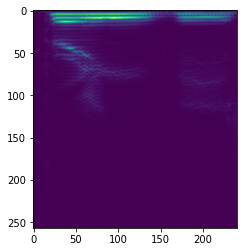

In [15]:
plt.figure()
plt.imshow(tf.transpose(spectrogram1)[0])
plt.show()

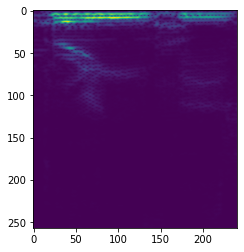

In [16]:
plt.figure()
plt.imshow(tf.transpose(spectrogram2)[0])
plt.show()

# Build the dataset

In [17]:
def convert_real_spectrogram_set(wav1, wav2):
    wav1 = tf.squeeze(wav1)
    spectrogram1 = tf.signal.stft(wav1, frame_length = 320, frame_step = 32)
    spectrogram1 = tf.math.real(spectrogram1)
    spectrogram1 = tf.expand_dims(spectrogram1, axis = 2)
    
    wav2 = tf.squeeze(wav2)
    spectrogram2 = tf.signal.stft(wav2, frame_length = 320, frame_step = 32)
    spectrogram2 = tf.math.real(spectrogram2)
    spectrogram2 = tf.expand_dims(spectrogram2, axis = 2)
    return spectrogram1, spectrogram2

In [18]:
def convert_imag_spectrogram_set(wav1, wav2):
    wav1 = tf.squeeze(wav1)
    spectrogram1 = tf.signal.stft(wav1, frame_length = 320, frame_step = 32)
    spectrogram1 = tf.math.imag(spectrogram1)
    spectrogram1 = tf.expand_dims(spectrogram1, axis = 2)
    
    wav2 = tf.squeeze(wav2)
    spectrogram2 = tf.signal.stft(wav2, frame_length = 320, frame_step = 32)
    spectrogram2 = tf.math.imag(spectrogram2)
    spectrogram2 = tf.expand_dims(spectrogram2, axis = 2)
    return spectrogram1, spectrogram2

In [19]:
def get_dataset(x_train, y_train):
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    return dataset

In [20]:
train_dataset = get_dataset(noisy_train, clean_train)

In [21]:
train_dataset_real = train_dataset.map(convert_real_spectrogram_set)
train_dataset_real = train_dataset_real.cache()
train_dataset_real = train_dataset_real.shuffle(buffer_size=100)
train_dataset_real = train_dataset_real.batch(64, drop_remainder=True)
train_dataset_real = train_dataset_real.prefetch(10)

In [22]:
train_dataset_real

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None))>

In [23]:
train_dataset_imag = train_dataset.map(convert_imag_spectrogram_set)
train_dataset_imag = train_dataset_imag.cache()
train_dataset_imag = train_dataset_imag.shuffle(buffer_size=100)
train_dataset_imag = train_dataset_imag.batch(64, drop_remainder=True)
train_dataset_imag = train_dataset_imag.prefetch(10)

In [24]:
train_dataset_imag

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None))>

In [25]:
test_dataset = get_dataset(noisy_train, clean_train)

In [26]:
test_dataset_real = test_dataset.map(convert_real_spectrogram_set)
test_dataset_real = test_dataset_real.batch(64, drop_remainder=True)
test_dataset_real = test_dataset_real.prefetch(10)

In [27]:
test_dataset_imag = test_dataset.map(convert_imag_spectrogram_set)
test_dataset_imag = test_dataset_imag.batch(64, drop_remainder=True)
test_dataset_imag = test_dataset_imag.prefetch(10)

In [28]:
test_dataset_real

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(64, 241, 257, 1), dtype=tf.float32, name=None))>

# Build the CNN model

In [29]:
def build_CNN_toy_model(l2_strength):
    inputs = Input(shape=(241, 257, 1))
    x = inputs

    # Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'valid')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding = 'same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding = 'same')(x)
    
    #Decoder
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides = 2, activation = 'relu', padding = 'same')(x)
    x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides = 2, activation = 'relu', padding = 'valid')(x)
    
    x = tf.keras.layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)
    
    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-4)

    model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [103]:
def build_CED_model(l2_strength):
    inputs = Input(shape=(241, 257, 1))
    x = inputs

    # -----
    x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip0)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # -----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(skip1)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip1
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = x + skip0
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # ----
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)
    x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

    model = Model(inputs=inputs, outputs=x)

    optimizer = tf.keras.optimizers.Adam(3e-3)

    model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    return model

In [104]:
model_real = build_CED_model(l2_strength=0.0)
model_real.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 241, 257, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 249, 257, 1)  0          ['input_4[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 241, 257, 18  162         ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

 conv2d_18 (Conv2D)             (None, 241, 257, 18  1296        ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 activation_9 (Activation)      (None, 241, 257, 18  0           ['conv2d_18[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 241, 257, 18  72         ['activation_9[0][0]']           
 rmalization)                   )                                                                 
                                                                                                  
 conv2d_19 (Conv2D)             (None, 241, 257, 30  2700        ['batch_normalization_9[0][0]']  
          

In [105]:
history_real = model_real.fit(train_dataset_real,
        steps_per_epoch=10,
#         validation_data = test_dataset,
        epochs=5,
)

Epoch 1/5
10/10 [==============================] - 858s 84s/step - loss: 1.1896 - rmse: 1.0907
Epoch 2/5
10/10 [==============================] - 718s 72s/step - loss: 0.3066 - rmse: 0.5537
Epoch 3/5
10/10 [==============================] - 702s 70s/step - loss: 0.2064 - rmse: 0.4543
Epoch 4/5
10/10 [==============================] - 705s 70s/step - loss: 0.1801 - rmse: 0.4244
Epoch 5/5
10/10 [==============================] - 652s 65s/step - loss: 0.1033 - rmse: 0.3213


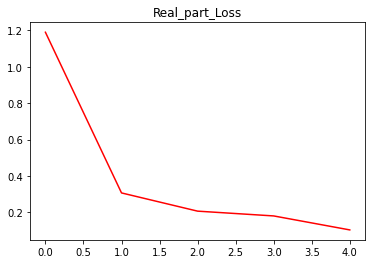

In [106]:
# plot the loss
plt.title('Real_part_Loss')
plt.plot(history_real.history['loss'], 'r')
plt.show()

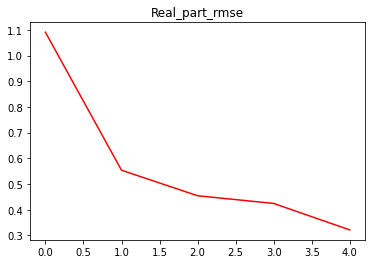

In [107]:
# plot the rmse
plt.title('Real_part_rmse')
plt.plot(history_real.history['rmse'], 'r')
plt.show()

In [108]:
model_imag = build_CED_model(l2_strength=0.0)

In [109]:
history_imag = model_imag.fit(train_dataset_imag,
        steps_per_epoch=10,
#         validation_data = test_dataset,
        epochs=5,
)

Epoch 1/5
10/10 [==============================] - 643s 64s/step - loss: 1.0659 - rmse: 1.0324
Epoch 2/5
10/10 [==============================] - 670s 68s/step - loss: 0.2410 - rmse: 0.4909
Epoch 3/5
10/10 [==============================] - 696s 69s/step - loss: 0.1395 - rmse: 0.3734
Epoch 4/5
10/10 [==============================] - 697s 70s/step - loss: 0.1104 - rmse: 0.3323
Epoch 5/5
10/10 [==============================] - 677s 67s/step - loss: 0.0655 - rmse: 0.2559


# Test the model

In [38]:
X_test_real, y_test_real = list(test_dataset_real.as_numpy_iterator())[0]

In [110]:
h_test_real = model_real.predict(X_test_real)

2/2 [==============================] - 10s 5s/step


In [111]:
h_test_real[0].shape

(241, 257, 1)

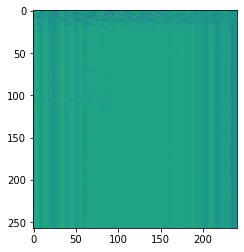

In [112]:
plt.figure()
plt.imshow(tf.transpose(h_test_real[22])[0])
plt.show()

In [113]:
plt.figure()
plt.imshow(tf.transpose(y_test_real[22])[0])
plt.show()

In [50]:
X_test_imag, y_test_imag = list(test_dataset_imag.as_numpy_iterator())[0]

In [114]:
h_test_imag = model_imag.predict(X_test_imag)

2/2 [==============================] - 10s 5s/step


In [115]:
plt.figure()
plt.imshow(tf.transpose(h_test_imag[2])[0])
plt.show()

In [116]:
plt.figure()
plt.imshow(tf.transpose(y_test_imag[2])[0])
plt.show()

In [117]:
plt.figure()
plt.imshow(tf.transpose(y_test_real[2]**2 + y_test_imag[2]**2)[0])
plt.show()

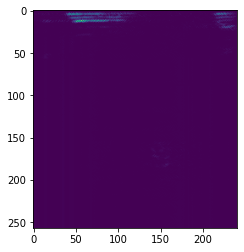

In [119]:
plt.figure()
plt.imshow(tf.transpose(h_test_real[2]**2 + h_test_imag[2]**2)[0])
plt.show()

In [70]:
def spectrogram_to_audio(sp):
    sp = tf.squeeze(sp)
    wav = tf.signal.inverse_stft(sp, frame_length = 320, frame_step = 32, window_fn=tf.signal.inverse_stft_window_fn(32))
    return wav

In [65]:
h_test_real[2].shape

(241, 257, 1)

In [85]:
test_clean_train.shape

TensorShape([6025, 8000, 1])

In [133]:
test1 = test_clean_train[0:129]
test1 = tf.reshape(test1 ,[-1])

In [87]:
test1.shape

TensorShape([48200000])

In [120]:
sp_test = tf.complex(h_test_real, h_test_imag)

In [121]:
sp_test.shape

TensorShape([64, 241, 257, 1])

In [122]:
for i in range(64):
    test_wav = tf.concat([test_wav, spectrogram_to_audio(sp_test[i])], 0)

In [123]:
test_wav.shape

TensorShape([1032000])

In [135]:
from IPython.display import Audio
Audio(test1, rate=48000)

In [136]:
Audio(test_wav, rate=18000)